In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from htorch import layers
import time

In [2]:
device = torch.device('cuda:0')

data = torch.tensor(pd.read_csv("../data/mnist/train.csv", header=None).values)
x, y = (data[:, 1:]/255).float().to(device), torch.nn.functional.one_hot(data[:, 0].long(), 10).to(device)

test = torch.tensor(pd.read_csv("../data/mnist/test.csv", header=None).values)
x_test, y_test = (test[:, 1:]/255).float().to(device), torch.nn.functional.one_hot(test[:, 0].long(), 10).to(device)

In [3]:
class Quat(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = layers.QLinear(196, 75)
        self.fc2 = layers.QLinear(75, 25)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x
        # comment above parts and uncomment 
        # below while time profiling
        t = 0
        # x = torch.flatten(x, 1)
        x, tp = self.fc1(x)
        t += tp
        x = F.relu(x)
        x, tp = self.fc2(x)
        t += tp
        x = F.relu(x)
        x = self.fc3(x)
        return x, t
model = Quat()
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1.2e-3)
losses = []
trainacc = []
testacc =[]

/home/aritra/project/quartLT23/htorch/quaternion.py:494: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:350.)
  if self.dim() == 1:
/home/aritra/project/quartLT23/htorch/quaternion.py:497: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:350.)
  out = self.q[:, :self.shape[1] // 4]
/home/aritra/project/quartLT23/htorch/quaternion.py:503: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:350.)
  if self.dim() == 1:
/home/aritra/project/quartLT23/htorch/quaternion.py:507: UserWarning: Defining your `_

In [4]:
t_f = 0
t_b = 0
t_h = 0

for epoch in tqdm(range(1000)):
    batch_size = 2**13
    for i in range(0, len(x), batch_size):
        batch_x, batch_y = x[i:i+batch_size], y[i:i+batch_size].float()
        optimiser.zero_grad()
        t0 = time.time()
        output, t = model(batch_x)
        t_h += t
        t_f += time.time() - t0
        t0 = time.time()
        loss = F.mse_loss(output, batch_y)
        loss.backward()
        t_b += time.time() - t0
        optimiser.step()
    losses.append(loss.item())
t_f, t_h, t_b

100%|██████████| 1000/1000 [00:17<00:00, 56.70it/s]


(2.5482687950134277, 0, 4.189775466918945)

Training Accuracy: 99.87%
Testing Accuracy: 97.48%


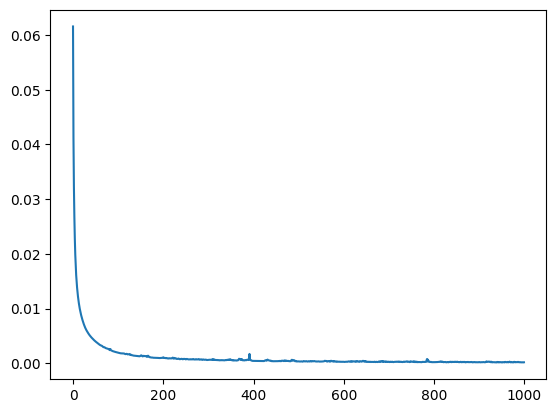

In [5]:
accuracy = (model(x)[0].argmax(1) == y.argmax(1)).sum().item()/len(x)
print(f"Training Accuracy: {accuracy*100:.2f}%")

accuracy = (model(x_test)[0].argmax(1) == y_test.argmax(1)).sum().item()/len(x_test)
print(f"Testing Accuracy: {accuracy*100:.2f}%")

plt.plot(range(len(losses)), losses)

In [6]:
# for epoch in tqdm(range(80)):
#     batch_size = 60
#     for i in range(0, len(x), batch_size):
#         batch_x, batch_y = x[i:i+batch_size], y[i:i+batch_size].float()
#         optimiser.zero_grad()
#         output = model(batch_x)
#         loss = F.mse_loss(output, batch_y)
#         loss.backward()
#         optimiser.step()
#     losses.append(loss.item())
    
#     accuracy = (model(x).argmax(1) == y.argmax(1)).sum().item()/len(x)
#     trainacc.append(accuracy)
#     # print(f"Training Accuracy: {accuracy*100:.2f}%")

#     accuracy = (model(x_test).argmax(1) == y_test.argmax(1)).sum().item()/len(x_test)
#     # print(f"Testing Accuracy: {accuracy*100:.2f}%")
#     testacc.append(accuracy)

# plt.plot(range(len(trainacc)), trainacc, label='training')
# plt.plot(range(len(testacc)), testacc,label = 'testing')
# plt.legend()